<a href="https://colab.research.google.com/github/Computational-physics-with-learning/Guest-presentations/blob/main/AlexanderDenker_HelsinkiTomographyChallenge/HelsinkiTomographyChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install packages

%%capture
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.001
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.002
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.003
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.004
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.005
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.006
!wget -nc https://github.com/Computational-physics-with-learning/Guest-presentations/raw/main/AlexanderDenker_HelsinkiTomographyChallenge/compressed/files.7z.007

!7z x -aos files.7z.001
import os
for i in range(1,8):
    os.remove(f'files.7z.00{i}')

import shutil
try:
    shutil.rmtree('sample_data') # bloody waste of space
except FileNotFoundError:
    pass

!pip install https://github.com/odlgroup/odl/archive/master.zip --upgrade
!apt-get install automake libtool
!pip install astra-toolbox

# Setting 

Organized by the Finish Inverse Problem Society to evaluate reconstruction algorithms for limited angle CT. Running from August - October 2022. 

Joint work with: Clemens Arndt, Sören Dittmer, Johannes Leuschner, Judith Nickel, Maximillian Schmidt


# Goal: Limited Angle CT Reconstruction 

- Provide a **segmentation** (material / background) of the target from limited angle CT data 
- Every method, algorithm, framework could be used 

The challenge was split into $7$ levels, starting at a $90^\circ$ angular range and going down to $30^\circ$. The angular increment was $0.5^\circ$.

| Level | Angular Range | Number of projections |
|:-----:|---------------|-----------------------|
|   1   |       90      | 181                   |
|   2   |       80      | 161                   |
|   3   |       70      | 141                   |
|   4   |       60      | 121                   |
|   5   |       50      | 101                   |
|   6   |       40      | 81                    |
|   7   |       30      | 61                    |

The specific angular subset, i.e. **the starting angle**, was only provided during the evaluation. Our method should work for different subset $[\phi_1, \phi_2]$, i.e. different subsampling patterns of the forward operator. 


## Evaluation

The segmentations are judged based on the Matthews correlation coefficient (MCC). The MCC is in the range of $[-1, 1]$ with $+1$ a perfect segmentation, $0$ a random segmentation and $-1$ if every pixel is wrong. For each level they evaluated three phantoms. The final score per level is the sum of the scores for the three phantoms. 

## Data 

The organizers provided $5$ examples. For each example they included: 
    
1. the full view ($360^\circ$, i.e. $721$ projections) sinogram, 
2. Filtered-Backprojection reconstruction, 
3. Segmentation of FBP reconstruction 

Dimension: images $512 \times 512$, sinograms $721 \times 560$.

They also provided information about the geometry of the CT scanner used. 

In [2]:
#@title import packages
import odl 
from odl.contrib.torch import OperatorModule

import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.transforms.functional import rotate


from scipy.io import loadmat
from scipy.ndimage.morphology import binary_closing

import numpy as np 
import matplotlib.pyplot as plt 
import yaml 
import math, random
from typing import List, Tuple
from PIL import Image, ImageDraw


In [3]:
#@title Setup dictionary
step_to_angular_idx = {
    1: 181,
    2: 161,
    3: 141,
    4: 121,
    5: 101,
    6: 81,
    7: 61
}

step_to_angular_range = {
    1: 90,
    2: 80,
    3: 70,
    4: 60,
    5: 50,
    6: 40,
    7: 30
}

In [4]:
#@title Setup data sets
angular_range_to_idx = {
    90: 181,
    80: 161,
    70: 141,
    60: 121,
    50: 101,
    40: 81,
    30: 61
}


class ChallengeData(Dataset):
    """
    Load the 5 phantom provided by the challenge organizers
    """
    def __init__(self,  angular_range, random_start_angle = False, base_dir = "htc_data/", include_fbp=False):
        
        self.angular_range = angular_range
        self.random_start_angle = random_start_angle

        self.base_dir = base_dir

        # [sinogram, segmentation, fbp]
        self.files = [["htc2022_solid_disc_full.mat", "htc2022_solid_disc_full_recon_fbp_seg.mat", "htc2022_solid_disc_full_recon_fbp.mat"], 
                      ["htc2022_ta_full.mat", "htc2022_ta_full_recon_fbp_seg.mat", "htc2022_ta_full_recon_fbp.mat"], 
                      ["htc2022_tb_full.mat", "htc2022_tb_full_recon_fbp_seg.mat", "htc2022_tb_full_recon_fbp.mat"], 
                      ["htc2022_tc_full.mat", "htc2022_tc_full_recon_fbp_seg.mat", "htc2022_tc_full_recon_fbp.mat"], 
                      ["htc2022_td_full.mat", "htc2022_td_full_recon_fbp_seg.mat", "htc2022_td_full_recon_fbp.mat"]]

        self.include_fbp = include_fbp

        if self.random_start_angle:
            print("WARNING: random_start_angle in ChallengeData is set to TRUE. \n You have to define the RayTrafo and FBP to use [start_angle, start_angle + angular_range] (Default is [0, angular_range]).")


    def __len__(self):
        return len(self.files)

    def __getitem__(self, IDX):

        disk_file = self.files[IDX]

        t_full = loadmat(os.path.join(self.base_dir, disk_file[0]), struct_as_record=False, simplify_cells=True)
        t_seg = loadmat(os.path.join(self.base_dir, disk_file[1]), struct_as_record=False, simplify_cells=True)

        if self.include_fbp:
            t_fbp = loadmat(os.path.join(self.base_dir, disk_file[2]), struct_as_record=False, simplify_cells=True)
            t_fbp = torch.from_numpy(t_fbp['reconFullFbp']).unsqueeze(0).float()

        if self.random_start_angle:
            start_angle = np.random.randint(low=0, high=721 - angular_range_to_idx[self.angular_range])
            stop_angle = start_angle + angular_range_to_idx[self.angular_range]

        else:
            start_angle = 0
            stop_angle = angular_range_to_idx[self.angular_range]

        t_sino = torch.from_numpy(t_full['CtDataFull']['sinogram'][start_angle:stop_angle, :]).unsqueeze(0).float()

        t_seg = torch.from_numpy(t_seg['reconFullFbpSeg']).unsqueeze(0).float()

        if self.include_fbp:

            return t_sino, t_seg, torch.from_numpy(np.asarray([start_angle, stop_angle])), t_fbp 
        else:
            return t_sino, t_seg, torch.from_numpy(np.asarray([start_angle, stop_angle]))



class FullChallengeData(Dataset):
    """
    Load the 5 phantom provided by the challenge organizers
    """
    def __init__(self, base_dir = "htc_data/", include_fbp=False):
        
        self.base_dir = base_dir

        # [sinogram, segmentation, fbp]
        self.files = [["htc2022_solid_disc_full.mat", "htc2022_solid_disc_full_recon_fbp_seg.mat", "htc2022_solid_disc_full_recon_fbp.mat"], 
                      ["htc2022_ta_full.mat", "htc2022_ta_full_recon_fbp_seg.mat", "htc2022_ta_full_recon_fbp.mat"], 
                      ["htc2022_tb_full.mat", "htc2022_tb_full_recon_fbp_seg.mat", "htc2022_tb_full_recon_fbp.mat"], 
                      ["htc2022_tc_full.mat", "htc2022_tc_full_recon_fbp_seg.mat", "htc2022_tc_full_recon_fbp.mat"], 
                      ["htc2022_td_full.mat", "htc2022_td_full_recon_fbp_seg.mat", "htc2022_td_full_recon_fbp.mat"]]

        self.include_fbp = include_fbp


    def __len__(self):
        return len(self.files)

    def __getitem__(self, IDX):

        disk_file = self.files[IDX]

        t_full = loadmat(os.path.join(self.base_dir, disk_file[0]), struct_as_record=False, simplify_cells=True)
        t_seg = loadmat(os.path.join(self.base_dir, disk_file[1]), struct_as_record=False, simplify_cells=True)

        if self.include_fbp:
            t_fbp = loadmat(os.path.join(self.base_dir, disk_file[2]), struct_as_record=False, simplify_cells=True)
            t_fbp = torch.from_numpy(t_fbp['reconFullFbp']).unsqueeze(0).float()

       
        t_sino = torch.from_numpy(t_full['CtDataFull']['sinogram']).unsqueeze(0).float() 

        t_seg = torch.from_numpy(t_seg['reconFullFbpSeg']).unsqueeze(0).float()

        if self.include_fbp:

            return t_sino, t_seg, t_fbp 
        else:
            return t_sino, t_seg



class TestData(Dataset):
    """
    Load the 5 phantom provided by the challenge organizers
    """
    def __init__(self, level, base_dir = "htc_data/htc2022_test_data"):
        
        self.base_dir = base_dir
        self.level = level 

        # [sinogram, segmentation, fbp]
        self.files = [["htc2022_0{}a_limited.mat".format(self.level), "htc2022_0{}a_recon_fbp_seg.mat".format(self.level)], 
                      ["htc2022_0{}b_limited.mat".format(self.level), "htc2022_0{}b_recon_fbp_seg.mat".format(self.level)], 
                      ["htc2022_0{}c_limited.mat".format(self.level), "htc2022_0{}c_recon_fbp_seg.mat".format(self.level)]]


    def __len__(self):
        return len(self.files)

    def __getitem__(self, IDX):

        disk_file = self.files[IDX]

        t_limited = loadmat(os.path.join(self.base_dir, disk_file[0]), struct_as_record=False, simplify_cells=True)
        t_seg = loadmat(os.path.join(self.base_dir, disk_file[1]), struct_as_record=False, simplify_cells=True)

        angles = t_limited["CtDataLimited"]["parameters"]["angles"]
       
        t_sino = torch.from_numpy(t_limited['CtDataLimited']['sinogram']).unsqueeze(0).float() 
        t_seg = torch.from_numpy(t_seg['reconFullFbpSeg']).unsqueeze(0).float()

        return t_sino, t_seg, angles 


In [5]:
#@title Define ray transform
import astra
def get_ray_trafo(start_angle, stop_angle, impl='astra_cuda' if astra.astra.use_cuda() else 'astra_cpu'):
    num_angles= 721
    det_shape = 560

    # hyperparameters in metadata of measurements
    M = 1.348414746992646 
    DistanceSourceDetector = 553.74
    DistanceSourceOrigin = 410.66
    effPixel = 0.1483223173330444

    DistanceDetectorOrigin = DistanceSourceDetector - DistanceSourceOrigin

    angle_partition = odl.uniform_partition_fromgrid(
                odl.discr.grid.RectGrid(np.linspace(0, 360, 721)*np.pi/180))[start_angle:stop_angle]
                    
    det_partition = odl.uniform_partition(-M*det_shape/2, M*det_shape/2, det_shape)

    geometry =  odl.tomo.geometry.conebeam.FanBeamGeometry(angle_partition, det_partition, 
                                                        src_radius=DistanceSourceOrigin/effPixel , 
                                                        det_radius=DistanceDetectorOrigin/effPixel,
                                                        src_to_det_init=(-1, 0))
    space = odl.discr.discr_space.uniform_discr([-256,-256], [256,256], (512, 512), dtype=np.float32)

    ray_trafo = odl.tomo.RayTransform(space, geometry, impl=impl)

    return ray_trafo

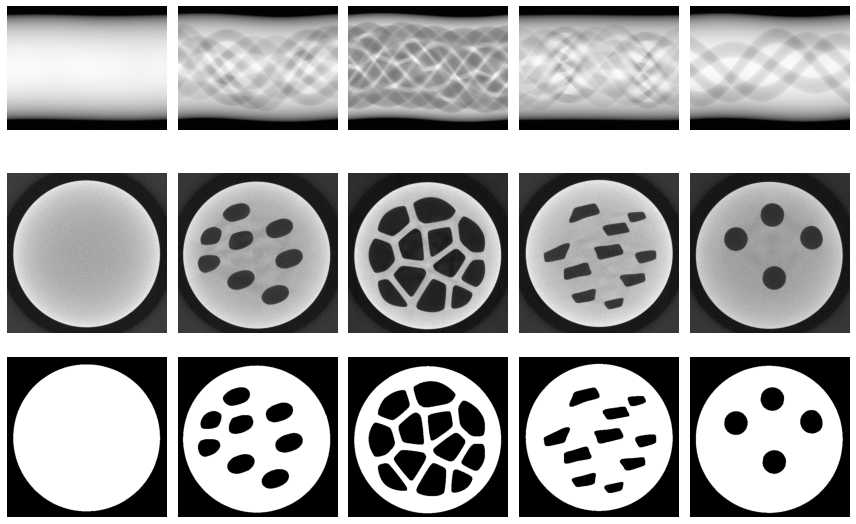

In [6]:
#@title Look at data set
# = "/content/drive/MyDrive/HelsinkiTomographyChallenge"

dataset = FullChallengeData(base_dir="htc_data", include_fbp=True)

fig, axes = plt.subplots(3, len(dataset), figsize=(12,8))
for i in range(len(dataset)):
    sino, seg, fbp = dataset[i]

    axes[0, i].imshow(sino[0,:,:].T, cmap="gray")
    axes[0, i].axis("off")

    axes[1, i].imshow(fbp[0,:,:], cmap="gray")
    axes[1, i].axis("off")

    axes[2, i].imshow(seg[0,:,:], cmap="gray")
    axes[2, i].axis("off")

fig.tight_layout()
plt.show()


### Why is limited angle CT hard?

We can only reliable reconstruct edges which are orthogonal to the view angles. The rest must somehow be "inpainted". In particular for limited angle CT we must set a strong prior on our image space. 

 You have to define the RayTrafo and FBP to use [start_angle, start_angle + angular_range] (Default is [0, angular_range]).


/usr/local/lib/python3.8/dist-packages/odl/tomo/backends/astra_cpu.py:318: RuntimeWarning: The 'astra_cpu' backend may be too slow for volumes of this size. Consider using 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(


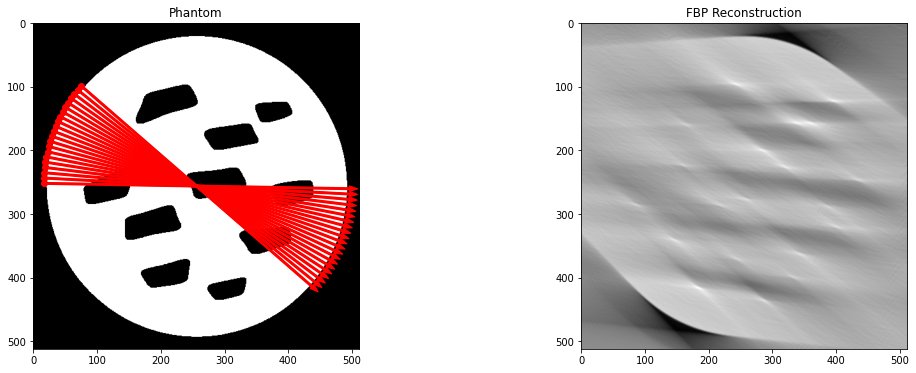

In [7]:
challenge_set = ChallengeData(angular_range=40, random_start_angle=True)

y, x, angles = challenge_set[3]

ray_trafo = get_ray_trafo(start_angle=angles[0], stop_angle=angles[-1])

fbp_op = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo, frequency_scaling=0.75, filter_type='Hann')

ray_trafo_torch = OperatorModule(ray_trafo)
fbp_op_torch = OperatorModule(fbp_op)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.imshow(x[0,:,:], cmap="gray")
fbp_reco = fbp_op_torch(y.unsqueeze(0))
ax2.imshow(fbp_reco[0,0,:,:], cmap="gray")

def get_line(phi, u, t=np.linspace(-1.5,1.5,150)):
    return u*np.array([[-np.sin(phi - np.pi/2)],[np.cos(phi - np.pi/2)]]) + t * np.array([[-np.sin(phi)], [np.cos(phi)]])

for phi in ray_trafo.geometry.angles[0::4]:
    line = get_line(-phi, 0, t=-np.linspace(-240,240,10))

    ax1.plot(line[0,:]+256, line[1,:]+256, c="r",lw=3,ls="-")
    ax1.scatter(line[0,0]+256, line[1,0]+256, c="r")
    ax1.arrow(line[0,0]+256, line[1,0]+256, line[0,-1] - line[0,0] , line[1,-1] - line[1,0] ,
              color="r", width=1.5,head_width=9)

ax1.set_title("Phantom")    
ax2.set_title("FBP Reconstruction")
plt.show()


### Our Approach

Instead of training only on these 5 phantoms, our idea was to create synthetic phantoms, simulate measurements and train on this simulated data set.

For each level $k \in [90^\circ, \dots, 30^\circ]$: 

1. Build a forward operator $A:X \to Y$.
2. Create synthetic phantoms $x$. 
3. Collect a dataset $(x_i, Ax_i)$ of synthetic phantoms and simulated measurements.
4. Train a suitable neural network $f_\theta^k:Y \to X$.
5. Finetune on the $5$ challenge phantoms. 

**Note:** We used the same architecture and training setup for every level.




### How to deal with the random starting angle? 

We trained our model only on measurements of the angular rangle $[0, 30^\circ], \dots, [0, 90^\circ]$. During inference, we shifted the sinograms to start at $0^\circ$, did the reconstruction + segmentation and rotated the output back to the original ortientation. 

![](https://drive.google.com/uc?export=view&id=1wCH6YRAjPzaAI7-iPnE8u10ZR1bTP7vB)


## Forward Operator 

We use the `odl` toolbox (which internally uses the `astra` toolbox) to create a forward operator. Using the `OperatorModule` from `odl` we get a representation of the forward opertator as a `pytorch` module (this allows us to use all autodiff functionalities). In particular, we forward operator can be used as a "layer" of a neural network.

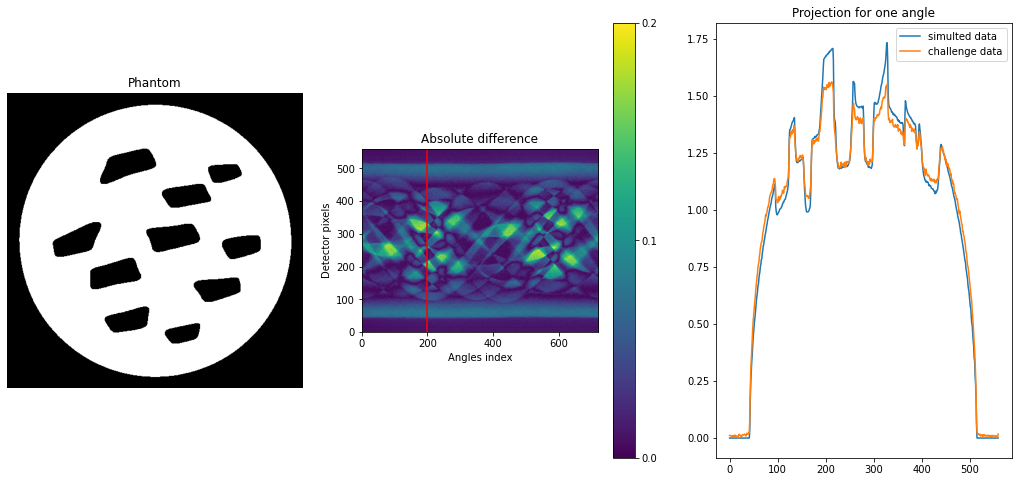

In [8]:
#@title Build forward operator and fbp
ray_trafo = get_ray_trafo(start_angle=0, stop_angle=721)

ray_trafo_torch = OperatorModule(ray_trafo)

sino, seg, fbp = dataset[3]

phantoms = seg.unsqueeze(0)

with torch.no_grad():
    y = ray_trafo_torch(phantoms)
    y = y / torch.mean(y)

sino = sino / torch.mean(sino)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18,8))

ax0.imshow(seg[0,:,:], cmap="gray")
ax0.axis("off")
ax0.set_title("Phantom")

im = ax1.imshow(np.abs(y.cpu().numpy()[0,0,:,:].T - sino.cpu().numpy()[0,:,:].T), vmin=0, vmax=0.2)
cbar = fig.colorbar(im, ax=ax1, ticks=[0, 0.1, 0.2])
ax1.set_xlabel("Angles index")
ax1.set_ylabel("Detector pixels")
ax1.set_ylim(0, 560)
ax1.set_title("Absolute difference")

idx = 200
ax1.vlines(idx, 0, 560, color='r')

ax2.plot(y.cpu().numpy()[0,0,idx,:], label="simulted data")
ax2.plot(sino.cpu().numpy()[0,idx,:], label="challenge data")
ax2.legend()
ax2.set_title("Projection for one angle")
plt.show() 

## How to create new phantoms? 

Assumption:
- Disk with the same diameter, but new types of holes

Included 4 types of holes:
  - non-overlapping circles of different diameter
  - random lines with different angles 
  - non-overlapping random polygones
  - levelsets of random gaussians

In [9]:
#@title Methods for creating new phantoms



class SimulatedPhantom(Dataset):
    """
    Generates a dataset containing synthesized phantoms.
    WARNING: two calls of getitem produce seperate samples
    """
    def __init__(self,subset, data_generation_methods = ["phantom_1", "phantom_2"], data_generation_probability = [1, 1] , length=100, max_iter=25, rotate=False):
        """
        :param length: legth of dataset (needed to define __len__)
        """

        self.length = length
        self.subset = subset
        self.max_iter = max_iter
        self.rotate = rotate

        assert len(data_generation_probability) == len(data_generation_probability), "Number of data generation methods and probabilities does not match!"

        self.data_generation_methods = data_generation_methods
        self.data_generation_probability = data_generation_probability/np.sum(data_generation_probability)

    def __len__(self):
        return self.length

    def __getitem__(self, IDX):

        disc_level = np.random.uniform(low=0.004, high=0.007)

        method = np.random.choice(self.data_generation_methods, p = self.data_generation_probability)

        if method == "phantom_1":
            phantom = create_phantom(max_iter=self.max_iter)
        if method == "phantom_2":
            phantom = create_phantom2()
        if method == "phantom_3":
            phantom = create_phantom3(max_iter=self.max_iter)
        if method == "phantom_4":
            phantom = create_phantom4()
        if method == "phantom_5":
            phantom = create_phantom5()
            

        phantom = torch.from_numpy(phantom).float()

        if self.rotate:
            angle = np.random.randint(-180, 180)
            phantom = rotate(phantom, angle)


        return phantom, phantom*disc_level

"""
Alex:

Create a disk with non-overlapping circular holes.
"""
def create_phantom(min_holes=0, max_holes = 15, max_iter=40):
    xx, yy = np.meshgrid(np.linspace(-1, 1, 512), np.linspace(-1, 1, 512))

    x_center = np.random.rand()*0.045 - 0.0225
    y_center = np.random.rand()*0.045 - 0.0225
    
    phantom = np.zeros((1, 512, 512))

    phantom[:, (xx - x_center)**2 + (yy-y_center)**2 < 0.85] = 1.0

    num_holes = np.random.randint(min_holes, max_holes)

    circle_list = [] 
    iter = 0
    while(len(circle_list) < num_holes):
        # create random center (x,y) and radius r
        x_c = (np.random.rand()*2 - 1)*0.5
        y_c = (np.random.rand()*2 - 1)*0.5
        radius = np.random.rand()*0.15 + 0.05

        collide = False
        for x, y, r in circle_list:
            d = np.sqrt((x_c - x)**2 + (y_c - y)**2)
            if d < np.sqrt(radius + r):
                collide = True
                break

        if not collide:
            circle_list.append((x_c, y_c, radius))

        iter = iter + 1 
        if iter > max_iter:
            break

    for x, y, r in circle_list:            
        phantom[:, (xx - x)**2 + (yy-y)**2 < r**2] = 0

    return phantom

"""
Clemens: 

Create a disk with holes using two sets of lines with different angles.
"""
def create_phantom2(center=None, radius=235, distance=32):
    '''
    Parameters
    ----------
    center : array, optional
        An array with 2 entries specifying the center.
        The default is a random location
    radius : int, optional
        The radius of the disc. The default is 235 (like the challenge data).
    distance : int, optional
        Specifies the distance between the holes. The smaller this value,
        the more holes are created. The default is 32.

    Returns
    -------
    phan : numpy array
        The phantom as a binary image (values zero and one).

    '''
    
    # Start with a black image
    phan = np.zeros([512,512], dtype='uint8')
    if center==None:
        center=255.5+3*np.random.randn(2)
    
    # Choose an angle by random            
    alph = np.pi*np.random.rand()
    
    nbr = int(2*radius/(3*distance))
    d2 = int(distance/2)
    
    for k in range(2):
        # draw white lines (not totally straight) with the selected angle
        for i in np.arange(nbr):
            px = center[0]-radius*np.cos(alph)-(i-(nbr-1)/2)*3*distance*np.sin(alph)
            py = center[1]-radius*np.sin(alph)+(i-(nbr-1)/2)*3*distance*np.cos(alph)
            gamma = alph + 0.02*np.random.randn()
            for j in np.arange(int(20*radius/distance)):
                phan[int(px)-d2:int(px)+d2,int(py)-d2:int(py)+d2]=1
                gamma = alph + 0.98*(gamma-alph) + 0.02*np.random.randn()
                px = px + distance/10*np.cos(gamma)
                py = py + distance/10*np.sin(gamma)
        #choose a second angle and repeat
        alph = alph + np.pi/6 + 2/3*np.pi*np.random.rand()
    

    xx, yy = np.meshgrid(np.linspace(0, 512, 512), np.linspace(0, 512, 512))

    circle_coordinates = (xx - center[0])**2 + (yy-center[1])**2 

    phan[circle_coordinates > radius**2] = 0.0
    phan[((radius-distance)**2 < circle_coordinates)  & (circle_coordinates < radius**2)] = 1.0


    # Do a morphological closing
    mask = np.ones([7,7])
    mask[0,[0,-1]]=0
    mask[-1,[0,-1]]=0
    phan = binary_closing(phan, structure=mask)
    
    return np.expand_dims(phan, 0)

"""
Alex:

Create a disk with generate_polygon.
"""
def create_phantom3(min_holes=3, max_holes = 15, max_iter=60, distance_between=10):
        
    I = np.zeros((512, 512))

    xx, yy = np.meshgrid(np.linspace(0, 512, 512), np.linspace(0, 512, 512))

    x_center = 256 + np.random.randint(-10, 10)
    y_center = 256 + np.random.randint(-10, 10)
        
    I[(xx - x_center)**2 + (yy-y_center)**2 < 235**2] = 1.0


    im = Image.fromarray(np.uint8(I))

    draw = ImageDraw.Draw(im)

    num_forms = np.random.randint(min_holes, max_holes)

    circle_list = [] 
    vertices_list = []
    iter = 0
    while(len(circle_list) < 8):
        avg_radius = np.random.randint(20, 60)
        
        center_x = 256 + np.random.randint(-120, 120)
        center_y = 256 + np.random.randint(-120, 120)

        collide = False
        for x, y, r in circle_list:
            d = (center_x - x)**2 + (center_y - y)**2
            if d < (avg_radius + r + distance_between)**2:
                collide = True
                break

        if not collide:
            num_vertices = np.random.randint(5, 9)
            vertices = generate_polygon(center=(center_x, center_y),
                                avg_radius=avg_radius,
                                irregularity=0.2,
                                spikiness=0.1,
                                num_vertices=num_vertices)
            
            vertices_list.append(vertices)
            circle_list.append((center_x, center_y, avg_radius))
            
        iter = iter + 1 
        if iter > max_iter:
            break

    for vertices in vertices_list:            
        draw.polygon(vertices, fill=0)


    phantom = np.asarray(im)

    mask = np.ones([7,7])
    mask[0,[0,-1]]=0
    mask[-1,[0,-1]]=0
    phantom = binary_closing(phantom, structure=mask)

    return np.expand_dims(phantom, 0)


def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon

    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * math.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(num_vertices):
        radius = clip(random.gauss(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * math.cos(angle),
                 center[1] + radius * math.sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points


def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * math.pi / steps) - irregularity
    upper = (2 * math.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * math.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles

def clip(value, lower, upper):
    """
    https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon

    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))

"""
Alex:

Create random forms by taking the level set of sums of gaussians
"""
def create_phantom4():
    xx, yy = np.meshgrid(np.linspace(-1, 1, 512), np.linspace(-1, 1, 512))

        
    phantom = np.zeros((512, 512))


    #pos = np.stack([xx.ravel(), yy.ravel()])
    for j in range(2):
        r = np.random.rand()*0.7
        for i in range(6):
            phi = np.random.rand()*2*np.pi

            x_mean = r*np.cos(phi)#np.random.rand()*1.8 - 0.9
            y_mean = r*np.sin(phi)#np.random.rand()*1.8 - 0.9
            x_std = 40 + np.random.rand()*20
            y_std = 40 + np.random.rand()*20

            cov = 10 + np.random.rand()*10
            phantom +=np.exp(-x_std*(xx - x_mean)**2 - y_std*(yy - y_mean)**2 + cov*(xx - x_mean)*(yy - y_mean))

        
        
    cut_off = np.quantile(phantom.ravel(), 0.7) # 0.75
    phantom[phantom > cut_off] = 1.0
    phantom[phantom <= cut_off] = 0.0

    phantom = 1 - phantom

    center=255.5+3*np.random.randn(2)

    radius=235+3*np.random.randn()
    distance=32

    xx, yy = np.meshgrid(np.linspace(0, 512, 512), np.linspace(0, 512, 512))

    circle_coordinates = (xx - center[0])**2 + (yy-center[1])**2 

    phantom[circle_coordinates > radius**2] = 0.0
    phantom[((radius-distance)**2 < circle_coordinates)  & (circle_coordinates < radius**2)] = 1.0

    return np.expand_dims(phantom, 0) 

"""
Alex:

Create a disk with generate_polygon and generate_polygon for the full object.
"""
def create_phantom5(min_holes=3, max_holes = 15, max_iter=60, distance_between=10):
            
    I = np.zeros((512, 512))
    im = Image.fromarray(np.uint8(I))

    draw = ImageDraw.Draw(im)

    x_center = 256 + np.random.randint(-10, 10)
    y_center = 256 + np.random.randint(-10, 10)

    num_vertices = np.random.randint(3, 13)
    vertices = generate_polygon(center=(x_center, y_center),
                                    avg_radius=220,
                                    irregularity=0.2,
                                    spikiness=0.1,
                                    num_vertices=num_vertices)

    draw.polygon(vertices, fill=1)

    num_forms = np.random.randint(1, 8)

    distance_between=10
    circle_list = [] 
    vertices_list = []
    iter = 0
    while(len(circle_list) < 8):
        avg_radius = np.random.randint(20, 60)

        center_x = 256 + np.random.randint(-120, 120)
        center_y = 256 + np.random.randint(-120, 120)

        collide = False
        for x, y, r in circle_list:
            d = (center_x - x)**2 + (center_y - y)**2
            if d < (avg_radius + r + distance_between)**2:
                collide = True
                break

        if not collide:
            num_vertices = np.random.randint(5, 9)
            vertices = generate_polygon(center=(center_x, center_y),
                                avg_radius=avg_radius,
                                irregularity=0.2,
                                spikiness=0.1,
                                num_vertices=num_vertices)

            vertices_list.append(vertices)
            circle_list.append((center_x, center_y, avg_radius))

        iter = iter + 1 
        if iter > 40:
            break

    for vertices in vertices_list:            
        draw.polygon(vertices, fill=0)

    phantom = np.asarray(im)


    mask = np.ones([7,7])
    mask[0,[0,-1]]=0
    mask[-1,[0,-1]]=0
    phantom = binary_closing(phantom, structure=mask)

    return np.expand_dims(phantom, 0)


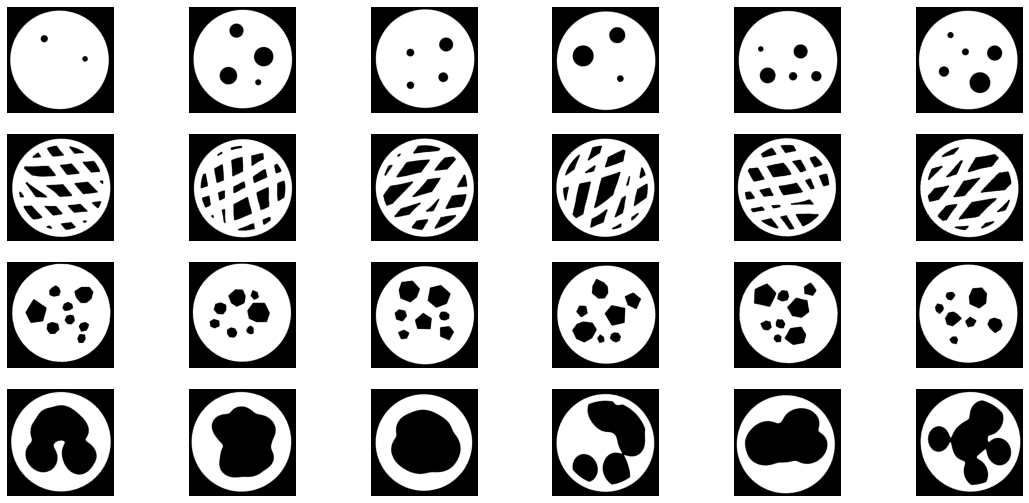

In [10]:
fig, axes = plt.subplots(4,6, figsize=(19,9))
for i in range(4):
  dataset = SimulatedPhantom(subset="train", rotate=True, data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"],
            data_generation_probability=[int(i==0), int(i==1), int(i==2), int(i==3)], length=200, max_iter=80)
  for j in range(6):
      phantoms_seg, phantoms = dataset[j]
      axes[i,j].imshow(phantoms_seg[0,:,:], cmap="gray")
      axes[i,j].axis("off")
plt.show()

dataset = SimulatedPhantom(subset="train", rotate=True, data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"],
            data_generation_probability=[2.25, 2.5, 3, 1.1], length=200, max_iter=80)

## Network Architecture 

Limited Angle CT is a hard problem, since a large part of features is simply not visible in the measurements. One can show, that we can only recover edges, that are orthogonal to the view angle. 

There are deep learning methods, which are specifically built for limited angle reconstruction:
- T. Bubba et al., *Learning The Invisible: A Hybrid Deep Learning-Shearlet Framework for Limited Angle Computed Tomography*
- A. Andrade-Loarca et al., *Deep Microlocal Reconstruction for Limited-Angle Tomography*

These methods use the obervations that specific features (edges with specific orientations, wavelet coefficients or parts of the wavefront set) cannot be reconstructed from limited view data. They build models which learn to inpaint these features and preserve visible features. By only learning the invisible these methods may also have better generalization properties. 

We implement a similar method, see the image below. The results were okay for larger angular ranges, but for the later levels it didn't perform as well.




![](https://drive.google.com/uc?export=view&id=1y2Pk1pyGw4CKdFE-9smQcG0W9SR604mV)

We have good experience with learned iterative methods and these kind of methods performed exellent on sparse angle CT and low-dose CT for us. As we had already existing codebases for these applications it was straightforward to expand these to limited angle data. 

The idea of learned iterative methods is to unroll an existing algorithm for minimizing the variational formulation
$$ \min_x \| A x - y^\delta \|_2^2 + R(x) $$

for a fixed number of steps and exchange parts of it with neural networks. 

A first example was **learned gradient descent**. Under the assumption that $R$ is convex we can use proximal gradient descent 

$$ x_{k+1} = \text{prox}_{\lambda R}(x_k - \lambda A^*(A x_k - y^\delta)), \quad k=0, 1, 2, \dots $$

for some initial value $x_0$. We unroll this iteration for $N \in \mathbb{N}$ steps and exchange the proximal mapping with networks $G_{\theta_k}:\mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}^n$:

$$ \begin{align} x_0 &= 0 \\ x_{k+1} &= G_{\theta_k}(x_k, A^*(A x_k - y^\delta)), \quad k=0, 1,\dots, N-1 \\ \hat{x} &= x_N(y^\delta) \end{align}$$

The parameters of the networks $G_{\theta_k}$ can be shared. The resulting network can either be trained iteration-by-iteration or end-to-end. 

In most work the networks $G_{\theta_k}$ are relativley shallow neural networks with the interpretation to find an optimal mixing between the gradient $A^*(A x_k - y^\delta)$ and the current iterate $x_k$. Further, $G_{\theta_k}$ can act as an implicit operator correction. 

However, it is important to stress, that we **lose all convergence properties of the underlying iterative algorithms**. I see it as a really good starting point for a network architecture. 

In prior projects we found experimentally that these unrolled methods also were able to generalize better than other architectures. Especially variants of learned primal dual worked very well. 

### Neural Network: Learned Primal Dual

Primal-Dual algorithm was introduced by Chambolle & Pock for convex optimization problems:

$$ \min_x F(Ax) + G(x)  $$

with $F:Y \to [0, +\infty]$ and $G:X \to [0, +\infty]$ being convex. For $\sigma, \tau > 0$ and $x_0, \bar{x}_0 \in X, y_0 \in Y, \theta \in [0,1]$ the primal-dual algorithm is defined by:

$$ y_{i+1} = \text{prox}_{\sigma F^*}(y_i + \sigma A \bar{x}_i) \\ 
   x_{i+1} = \text{prox}_{\tau G}(x_i - \tau A^* y_{i+1} ) \\
   \bar{x}_{i+1} = x_{i+1} + \theta (x_{i+1} - x_{i}) $$ 
   
   
The idea of Adler & Öktem for Learned Primal Dual was to unroll this algorithm for $N$ steps and replace all proximal mappings with neural networks. Further, they introduced additional memory channels:

$$ (y_{i+1}, h^Y_{i+1}) = \text{NN}_{\theta^d_i}(y_i, A x_i, y, h^Y_i) \\ 
   (x_{i+1}, h^X_{i+1}) = \text{NN}_{\theta^p_i}(x_i, A^* y_{i+1}, h^X_i) \\ 
   i = 0, \dots, N-1$$
   

with $x_N(y)$ as the final reconstruction. We choose $x_0 = A^\dagger y$ and $y_0 = 0$. 

Here $\text{NN}_{\theta^d_i}: Y \times Y \times Y \times Y^M \to Y \times Y^M$, $\text{NN}_{\theta^p_i}: X \times X \times X^M \to X \times X^M$ are seperate neural network for each unrolling step. The network is then trained by minimizing a loss function $l:X \times X \to \mathbb{R}$ on a dataset $(x^k, y^k)_{k=1}^K$:

$$ \min_{\theta^p_0, \dots, \theta^p_{N-1}, \theta^d_{0}, \dots, \theta^d_{N-1}} \frac{1}{K} \sum_{k=1}^K  l(x^k,x_N(y^k))$$


### Modifications


1. Replace the adjoint $A^*$ with the filtered back-projection $A^\dagger$ in the dual step (cf. A. Hauptmann et al., *Multi-Scale Learned Iterative Reconstruction*)
2. Use shallow CNN for the dual networks (I dont really know what the dual network should learn?)
3. Use larger U-Nets in the primal networks (3 downsampling steps 512 -> 256 -> 128)
4. Training for segmentation with binary cross entropy loss 
5. Normalized inputs $y^\delta \leftarrow y^\delta/\| y^\delta \|$ to always have unit norm

In [11]:
#@title Build U-Net

class UNet(nn.Module):

    def __init__(self, in_ch, out_ch, channels, skip_channels, kernel_size = 7, 
                 use_sigmoid=True, use_norm=True, num_groups=8, normalize_input=False):
        super(UNet, self).__init__()
        assert (len(channels) == len(skip_channels))

        self.scales = len(channels)
        self.use_sigmoid = use_sigmoid

        self.use_norm = use_norm
        self.num_groups = num_groups
        self.normalize_input = normalize_input

        if self.normalize_input:
            self.instance_norm = torch.nn.InstanceNorm2d(1)


        if not isinstance(kernel_size, tuple):
            self.kernel_size = [kernel_size]*self.scales 
        else:
            self.kernel_size = kernel_size

        assert (len(channels)) == len(self.kernel_size)

        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.inc = InBlock(in_ch, channels[0], use_norm=use_norm, kernel_size=1, num_groups=self.num_groups)
        for i in range(1, self.scales):
            self.down.append(DownBlock(in_ch=channels[i - 1],
                                       out_ch=channels[i],
                                       use_norm=use_norm, 
                                       kernel_size=self.kernel_size[i],
                                       num_groups=self.num_groups))
        for i in range(1, self.scales):
            self.up.append(UpBlock(in_ch=channels[-i],
                                   out_ch=channels[-i - 1],
                                   skip_ch=skip_channels[-i],
                                   use_norm=use_norm, 
                                   kernel_size=self.kernel_size[-i],
                                   num_groups=self.num_groups))
        self.outc = OutBlock(in_ch=channels[0],
                             out_ch=out_ch)

    def forward(self, x0):
        if self.normalize_input:
            x0 = self.instance_norm(x0)

        xs = [self.inc(x0), ]
        for i in range(self.scales - 1):
            xs.append(self.down[i](xs[-1]))
        x = xs[-1]
        for i in range(self.scales - 1):
            x = self.up[i](x, xs[-2 - i])
        return torch.sigmoid(self.outc(x)) if self.use_sigmoid else self.outc(x)


class DownBlock(nn.Module):

    def __init__(self, in_ch, out_ch, kernel_size=3, use_norm=True,num_groups=1):
        super(DownBlock, self).__init__()
        to_pad = int((kernel_size - 1) / 2)
        if use_norm:
            self.conv = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.GroupNorm(num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.GroupNorm(num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size, # one layer more
                          stride=1, padding=to_pad),
                nn.GroupNorm(num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True),)
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size,
                          stride=2, padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size, # one layer more
                          stride=1, padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True),)

    def forward(self, x):
        x = self.conv(x)
        return x

class InBlock(nn.Module):

    def __init__(self, in_ch, out_ch, kernel_size=3, use_norm=True, num_groups=1):
        super(InBlock, self).__init__()
        to_pad = int((kernel_size - 1) / 2)
        if use_norm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.GroupNorm(num_groups=num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True))
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class UpBlock(nn.Module):

    def __init__(self, in_ch, out_ch, skip_ch=4, kernel_size=3, use_norm=True,num_groups=1):
        super(UpBlock, self).__init__()
        to_pad = int((kernel_size - 1) / 2)
        self.skip = skip_ch > 0
        
        if use_norm:
            self.conv = nn.Sequential(
                nn.GroupNorm(num_groups, num_channels=in_ch + skip_ch),
                nn.Conv2d(in_ch + skip_ch, out_ch, kernel_size, stride=1,
                          padding=to_pad),
                nn.GroupNorm(num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.GroupNorm(num_groups, num_channels=out_ch),
                nn.LeakyReLU(0.2, inplace=True))
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch + skip_ch, out_ch, kernel_size, stride=1,
                          padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size,
                          stride=1, padding=to_pad),
                nn.LeakyReLU(0.2, inplace=True))
        if self.skip:
            if use_norm:
                self.skip_conv = nn.Sequential(
                    nn.Conv2d(out_ch, skip_ch, kernel_size=1, stride=1),
                    nn.GroupNorm(num_groups, num_channels=skip_ch),
                    nn.LeakyReLU(0.2, inplace=True))
            else:
                self.skip_conv = nn.Sequential(
                    nn.Conv2d(out_ch, skip_ch, kernel_size=1, stride=1),
                    nn.LeakyReLU(0.2, inplace=True))

        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.concat = Concat()

    def forward(self, x1, x2):
        x = self.up(x1)
        if self.skip:
            x2 = self.skip_conv(x2)
            x = self.concat(x, x2)
        x = self.conv(x)
        return x

class Concat(nn.Module):

    def __init__(self):
        super(Concat, self).__init__()

    def forward(self, *inputs):
        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]
       # print("CONCAT: ")
       # print("Shapes: ")
       # print("\t From down: ", inputs[0].shape)
       # print("\t From skip: ", inputs[1].shape)

        if (np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and
                np.all(np.array(inputs_shapes3) == min(inputs_shapes3))):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2,
                                   diff3:diff3 + target_shape3])
        return torch.cat(inputs_, dim=1)

class OutBlock(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.conv(x)
        return x

    def __len__(self):
        return len(self._modules)


In [12]:
class IterativeBlock(nn.Module):

    def __init__(self, n_in=3, n_out=1, n_memory=5, n_layer=3, internal_ch=32,
                 kernel_size=3, batch_norm=True, prelu=False, lrelu_coeff=0.2, num_groups=8):
        super(IterativeBlock, self).__init__()
        assert kernel_size % 2 == 1
        padding = (kernel_size - 1) // 2
        modules = []
        if batch_norm:
            modules.append(nn.InstanceNorm2d(n_in + n_memory))
        for i in range(n_layer-1):
            input_ch = (n_in + n_memory) if i == 0 else internal_ch
            modules.append(nn.Conv2d(input_ch, internal_ch,
                                     kernel_size=kernel_size, padding=padding))
            if batch_norm:
                modules.append(nn.GroupNorm(num_groups, num_channels=internal_ch))
            if prelu:
                modules.append(nn.PReLU(internal_ch, init=0.0))
            else:
                modules.append(nn.LeakyReLU(lrelu_coeff, inplace=True))
        modules.append(nn.Conv2d(internal_ch, n_out + n_memory,
                                 kernel_size=kernel_size, padding=padding))
        self.block = nn.Sequential(*modules)

    def forward(self, x):
        upd = self.block(x)
        return upd

class SegmentationPrimalDualNet(nn.Module):

    def __init__(self, n_iter, op, op_adj, n_primal=5, n_dual=5,
                 use_sigmoid=False, n_layer=4, internal_ch=32, kernel_size=3,
                 batch_norm=True, prelu=False, lrelu_coeff=0.2, normalize_sinogram=False, num_groups_dual=8, num_groups_primal=8):
        super(SegmentationPrimalDualNet, self).__init__()
        self.n_iter = n_iter
        self.op = op
        self.op_adj = op_adj

        self.op_init = op_adj 

        self.n_primal = n_primal
        self.n_dual = n_dual
        self.use_sigmoid = use_sigmoid
        self.normalize_sinogram = normalize_sinogram
        self.num_groups_dual = num_groups_dual
        self.num_groups_primal = num_groups_primal

        self.primal_blocks = nn.ModuleList()
        self.dual_blocks = nn.ModuleList()
        for it in range(n_iter):
            self.dual_blocks.append(IterativeBlock(
                n_in=3, n_out=1, n_memory=self.n_dual-1, n_layer=n_layer,
                internal_ch=internal_ch, kernel_size=kernel_size,
                batch_norm=batch_norm, prelu=prelu, lrelu_coeff=lrelu_coeff, num_groups=self.num_groups_dual))
            
            self.primal_blocks.append(UNet(in_ch = 1 + self.n_primal, 
                                    out_ch=1,
                                    channels=[16, 32, 64, 64], 
                                    skip_channels=[8,16, 32,32], 
                                    kernel_size=3, 
                                    use_sigmoid=False, 
                                    use_norm=True,
                                    normalize_input=False, 
                                    num_groups=self.num_groups_primal))

        self.segmentation_block = UNet(in_ch = self.n_primal, out_ch=1, channels=[16, 32, 64, 128], skip_channels=[8,8, 8,8], kernel_size=3, use_sigmoid=False, use_norm=True,
                                       normalize_input=False)

    def forward(self, y, it=-1, use_segmentation=True):
        if self.normalize_sinogram:
            y = y/torch.mean(y, dim=[1,2,3], keepdim=True)

        primal_cur = torch.zeros(y.shape[0], self.n_primal,
                                 *self.op.operator.domain.shape,
                                 device=y.device)
        
        # initialize x_0 as the FBP(y)
        if self.op_init is not None:
            primal_cur[:] = self.op_init(y)  

        # initialize y_0 with zeros
        dual_cur = torch.zeros(y.shape[0], self.n_dual,
                               *self.op_adj.operator.domain.shape,
                               device=y.device)

        n_iter = self.n_iter if it == -1 else min(self.n_iter, it)        
        for i in range(n_iter):
            primal_evalop = self.op(primal_cur[:, 1:2, ...])
            dual_update = torch.cat([dual_cur, primal_evalop, y], dim=1)
            dual_update = self.dual_blocks[i](dual_update)
            dual_cur = dual_cur + dual_update

            dual_evalop = self.op_adj(dual_cur[:, 0:1, ...])
            primal_update = torch.cat([primal_cur, dual_evalop], dim=1)
            primal_update = self.primal_blocks[i](primal_update)
            primal_cur = primal_cur + primal_update
                        
        if use_segmentation:
            x = self.segmentation_block(primal_cur)
            return x
        else:
            return primal_cur[:, 0:1, ...]

    def forward_full(self, y):
        if self.normalize_sinogram:
            y = y/torch.mean(y, dim=[1,2,3], keepdim=True)

        primal_cur = torch.zeros(y.shape[0], self.n_primal,
                                 *self.op.operator.domain.shape,
                                 device=y.device)
        if self.op_init is not None:
            primal_cur[:] = self.op_init(y)  # broadcast across dim=1
        dual_cur = torch.zeros(y.shape[0], self.n_dual,
                               *self.op_adj.operator.domain.shape,
                               device=y.device)
        
        full_output_x = []
        full_output_y = []
        
        for i in range(self.n_iter):
            primal_evalop = self.op(primal_cur[:, 1:2, ...])
            dual_update = torch.cat([dual_cur, primal_evalop, y], dim=1)
            dual_update = self.dual_blocks[i](dual_update)
            dual_cur = dual_cur + dual_update
            
            dual_evalop = self.op_adj(dual_cur[:, 0:1, ...])
            primal_update = torch.cat([primal_cur, dual_evalop], dim=1)
            primal_update = self.primal_blocks[i](primal_update)
            primal_cur = primal_cur + primal_update
            
            full_output_x.append(primal_cur)
            full_output_y.append(dual_cur)
            
        x = self.segmentation_block(primal_cur)
        full_output_x.append(x)
        
        return full_output_x, full_output_y

In [13]:

level = 1

limited_angle_dataset = ChallengeData(angular_range=step_to_angular_range[level])

sino, seg, angles = limited_angle_dataset[1]

# 1. load ray_trafo  
ray_trafo = get_ray_trafo(0, step_to_angular_idx[level])
fbp_op = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo, frequency_scaling=0.75, filter_type='Hann')

ray_trafo_torch = OperatorModule(ray_trafo)
fbp_op_torch = OperatorModule(fbp_op)

### create file structure
version_num = 0
path_parts = ["network_weights", "range=" + str(step_to_angular_range[level]), "version_" + str(version_num)]
log_dir = os.path.join(*path_parts)

with open(os.path.join(log_dir, "hparams.yml"), 'r') as h_file:
    hparams = yaml.safe_load(h_file)

model = SegmentationPrimalDualNet(n_iter=hparams["n_iter"], 
                            op=ray_trafo_torch, 
                            op_adj=fbp_op_torch, 
                            n_primal=hparams["n_primal"], 
                            n_dual=hparams["n_dual"], 
                            use_sigmoid=hparams["use_sigmoid"], 
                            n_layer=hparams["n_layer"],
                            internal_ch=hparams["internal_ch"], 
                            kernel_size=hparams["kernel_size"], 
                            batch_norm=hparams["batch_norm"],
                            normalize_sinogram=hparams["normalize_sinogram"])

model.load_state_dict(torch.load(os.path.join(log_dir, "model.pt"),  map_location=torch.device('cpu')))
model.eval()

SegmentationPrimalDualNet(
  (op): OperatorModule(RayTransform) ((512, 512) -> (181, 560))
  (op_adj): OperatorModule(OperatorComp) ((181, 560) -> (512, 512))
  (op_init): OperatorModule(OperatorComp) ((181, 560) -> (512, 512))
  (primal_blocks): ModuleList(
    (0): UNet(
      (down): ModuleList(
        (0): DownBlock(
          (conv): Sequential(
            (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): GroupNorm(8, 32, eps=1e-05, affine=True)
            (3): LeakyReLU(negative_slope=0.2, inplace=True)
            (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (5): GroupNorm(8, 32, eps=1e-05, affine=True)
            (6): LeakyReLU(negative_slope=0.2, inplace=True)
            (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (8): GroupNorm(8, 32, eps=1e-05, affine=True)
         

In [14]:
# hyperparameters

print("Number of unrolled iterations: ", hparams["n_iter"])
print("Memory for primal variable: ", hparams["n_primal"])
print("Memory for dual variable: ", hparams["n_dual"])

Number of unrolled iterations:  4
Memory for primal variable:  4
Memory for dual variable:  2


In [15]:
# Number of parameters
# dual network CNN
print("Parameters in dual network: ", sum(p.numel() for p in model.dual_blocks[0].parameters()))
# primal netwrok UNet
print("Parameters in primal network: ", sum(p.numel() for p in model.primal_blocks[0].parameters()))
# parameters in last bigger UNet 
print("Parameters in last segmentation block: ", sum(p.numel() for p in model.segmentation_block.parameters()))
# total number of parameters
print("Total parameters: ", sum(p.numel() for p in model.parameters()))

Parameters in dual network:  77762
Parameters in primal network:  370337
Parameters in last segmentation block:  641337
Total parameters:  2433733


### Comparison for the size of the network

Results for the LoDoPab-CT challenge in 2021:

![](https://drive.google.com/uc?export=view&id=1oKyl2sENi59PfXqj4ndW-OAaC-czZgKK)

### Training Setup 

1. Pretraining on synthetic data 
 - $(x, Ax + \eta)$ with $1\%$ relative Gaussian noise 
 - 250,000 optimizer steps with batch size $6$
 - learning rate `1e-4` and a step-wise learning rate schedule

2. Finetuning on challenge data
 - 2000 optimizer steps with learning rate `5e-6`


In [16]:
%%script false --no-raise-error
# Don't want to execute this cell because training is long!
# We will just load weights in next cell

# training with Binary cross entropy
criterion = torch.nn.BCEWithLogitsLoss()

# lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.75)


train_dataset = SimulatedPhantom(subset="train", length=1000, 
                    data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"], 
                    data_generation_probability=[2, 2.25, 3, 1])
val_dataset = SimulatedPhantom(subset="val", length=64,
                    data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"], 
                    data_generation_probability=[2, 2.25, 3, 1])

challenge_dataset = ChallengeData(angular_range=hparams["angular_range"])

full_angles = np.linspace(0, 360, 721)

for epoch in range(250):
    # train model in train-mode
    model.train()
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            phantoms_seg, phantoms = batch

            phantoms_seg = phantoms_seg.to("cuda")
            phantoms = phantoms.to("cuda")

            with torch.no_grad():
                y = full_ray_trafo_torch(phantoms)
                y_noise = y + hparams["rel_noise"]*torch.mean(torch.abs(y), dim=[1,2,3], keepdim=True)*torch.randn(y.shape).to("cuda")
                y_noise = torch.clamp(y_noise, 0)

            # select a random starting angle 
            start_angle = np.random.randint(low=0, high=721 - angular_range_to_idx[angular_range])
            stop_angle = start_angle + angular_range_to_idx[angular_range]

            y_in = y_noise[:,:,start_angle:stop_angle,:]

            x_hat = model(y_in)
            x_gt = rotate(phantoms_seg, -full_angles[start_angle])

            loss = criterion(x_hat, x_gt) 
            loss.backward()

            optimizer.step() 
            pbar.set_description("Training | loss {:.4f}".format(loss.mean().item()))
            pbar.update(1)

    # eval-model in eval mode
    # eval-loop - save model if new validation loss is lower

    scheduler.step()

## Evaluation

In [17]:
#@title Load Network for level

def load_network(level):
  # 1. load ray_trafo  
  ray_trafo = get_ray_trafo(0, step_to_angular_idx[level])
  fbp_op = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo, frequency_scaling=0.75, filter_type='Hann')

  ray_trafo_torch = OperatorModule(ray_trafo)
  fbp_op_torch = OperatorModule(fbp_op)
  ### create file structure
  version_num = 0
  path_parts = ["network_weights", "range=" + str(step_to_angular_range[level]), "version_" + str(version_num)]
  log_dir = os.path.join(*path_parts)

  with open(os.path.join(log_dir, "hparams.yml"), 'r') as h_file:
      hparams = yaml.safe_load(h_file)

  model = SegmentationPrimalDualNet(n_iter=hparams["n_iter"], 
                              op=ray_trafo_torch, 
                              op_adj=fbp_op_torch, 
                              n_primal=hparams["n_primal"], 
                              n_dual=hparams["n_dual"], 
                              use_sigmoid=hparams["use_sigmoid"], 
                              n_layer=hparams["n_layer"],
                              internal_ch=hparams["internal_ch"], 
                              kernel_size=hparams["kernel_size"], 
                              batch_norm=hparams["batch_norm"],
                              normalize_sinogram=hparams["normalize_sinogram"])

  model.load_state_dict(torch.load(os.path.join(log_dir, "model.pt"),  map_location=torch.device('cpu')))
  model.eval()

  return model


/usr/local/lib/python3.8/dist-packages/odl/tomo/backends/astra_cpu.py:318: RuntimeWarning: The 'astra_cpu' backend may be too slow for volumes of this size. Consider using 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(


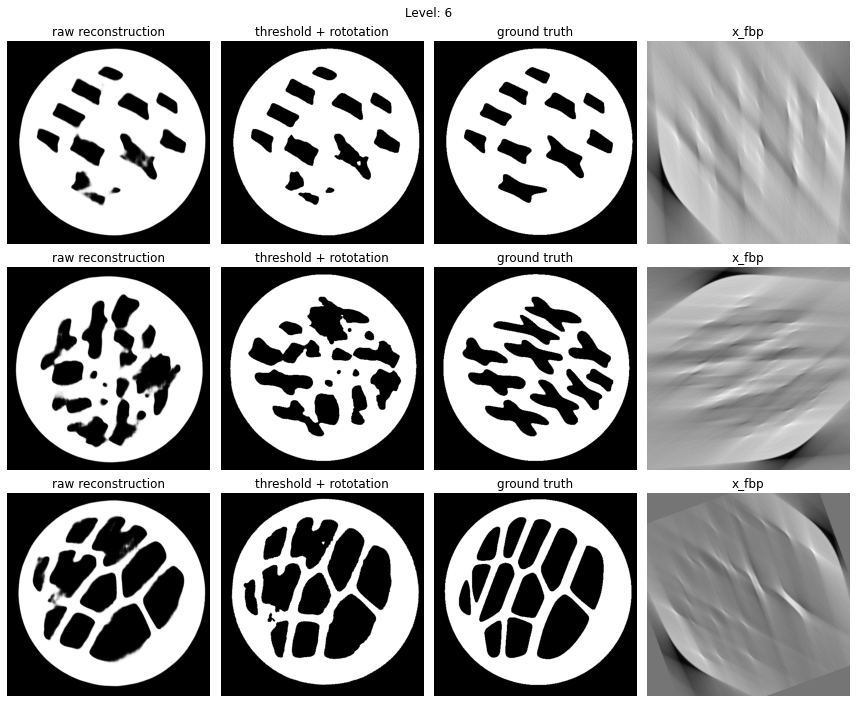

In [18]:
#@title Reconstruction for one level
level = 6

model = load_network(level)

test_data = TestData(level=level)

fig, axes = plt.subplots(len(test_data), 4, figsize=(12,10))
fig.suptitle("Level: " + str(level))
for i in range(len(test_data)):
  y, x, angles = test_data[i]
  y = y.unsqueeze(0)

  with torch.no_grad():
    x_fbp = rotate(model.op_init(y), angles[0]).cpu().detach().numpy()[0,0,:,:]

    x_hat = torch.sigmoid(model(y))

    x_seg = rotate(x_hat, angles[0]).cpu().detach().numpy()[0,0,:,:]
    x_seg[x_seg < 0.5] = 0.
    x_seg[x_seg >= 0.5] = 1.

  axes[i,0].imshow(x_hat[0,0,:,:].detach(), cmap="gray")
  axes[i,0].set_title("raw reconstruction")
  axes[i,0].axis("off")
  axes[i,1].imshow(x_seg, cmap="gray")
  axes[i,1].set_title("threshold + rototation")
  axes[i,1].axis("off")
  axes[i,2].imshow(x[0,:,:].detach(), cmap="gray")
  axes[i,2].set_title("ground truth")
  axes[i,2].axis("off")
  axes[i,3].imshow(x_fbp, cmap="gray")
  axes[i,3].set_title("x_fbp")
  axes[i,3].axis("off")
plt.tight_layout()
plt.show()




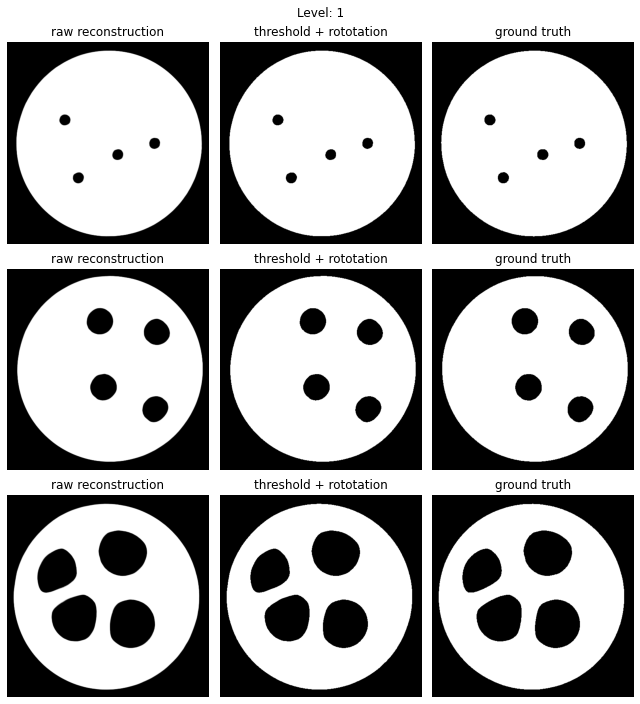

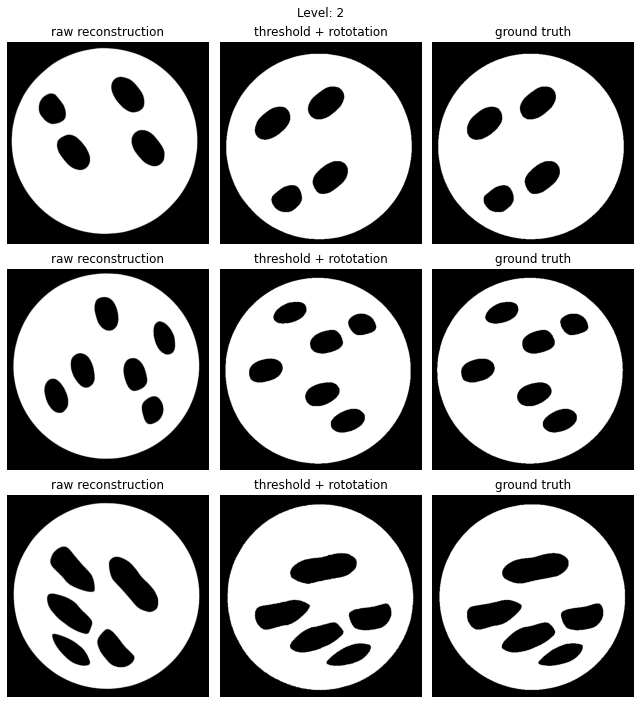

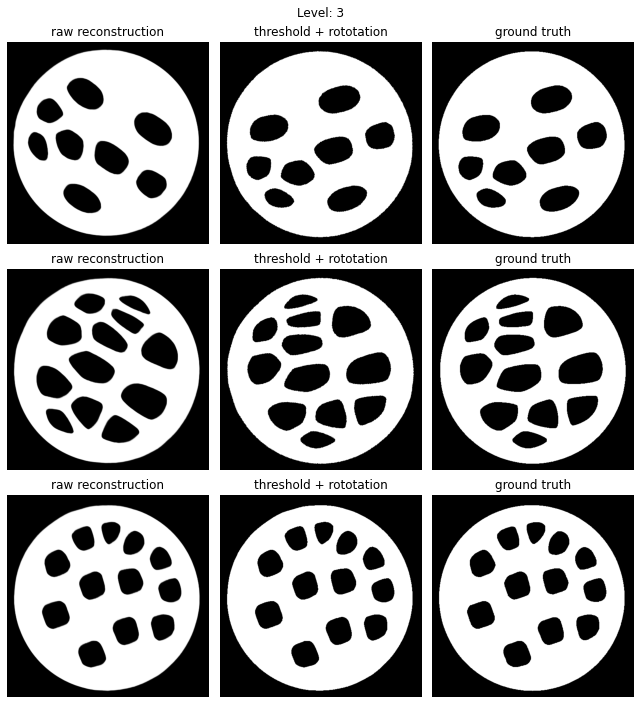

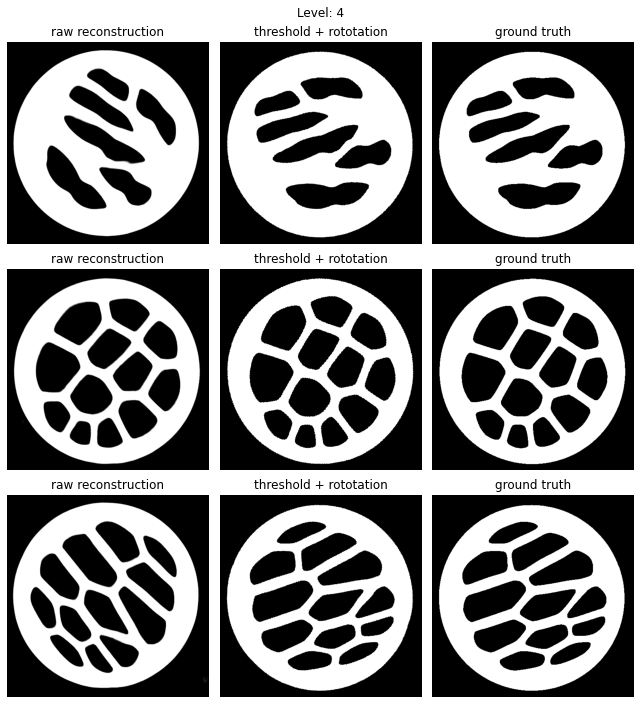

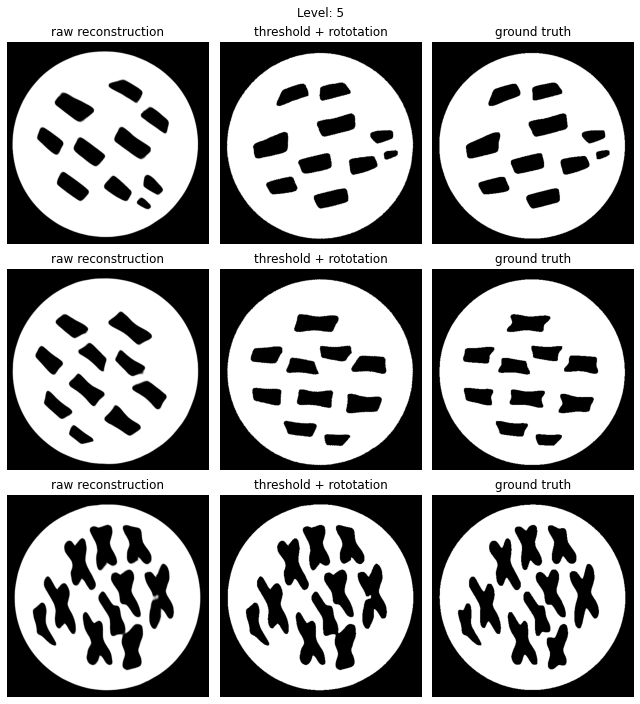

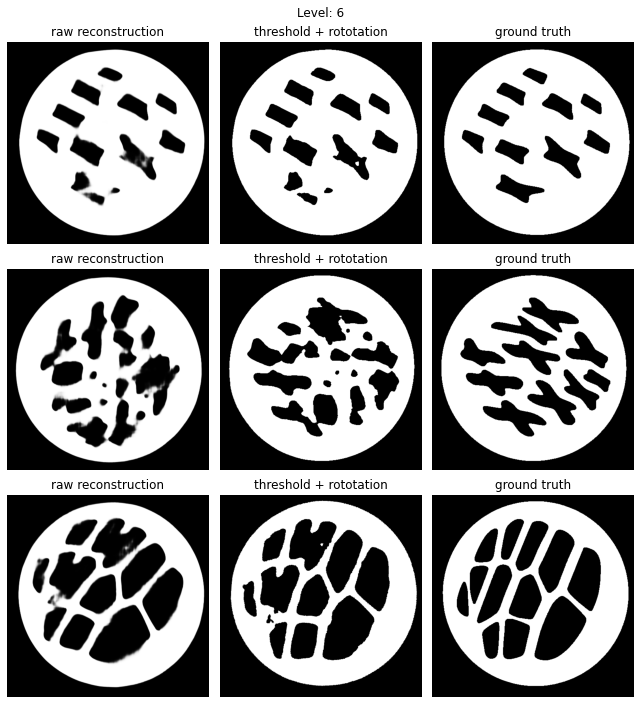

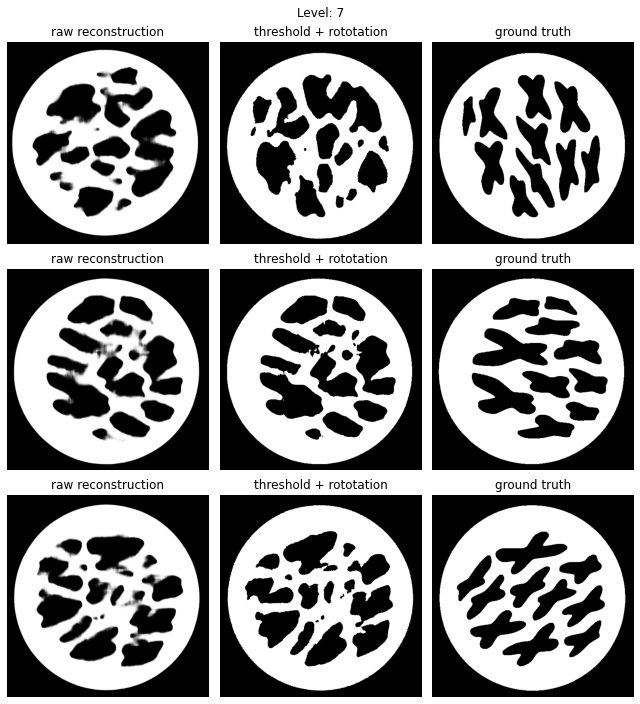

In [19]:
#@title Reconstruct all levels
for level in range(1,8):
  model = load_network(level)

  test_data = TestData(level=level)

  fig, axes = plt.subplots(len(test_data), 3, figsize=(9,10))
  fig.suptitle("Level: " + str(level))
  for i in range(len(test_data)):
    y, x, angles = test_data[i]
    y = y.unsqueeze(0)
    with torch.no_grad():

      x_hat = torch.sigmoid(model(y))

      x_seg = rotate(x_hat, angles[0]).cpu().detach().numpy()[0,0,:,:]
      x_seg[x_seg < 0.5] = 0.
      x_seg[x_seg >= 0.5] = 1.

    axes[i,0].imshow(x_hat[0,0,:,:].detach(), cmap="gray")
    axes[i,0].set_title("raw reconstruction")
    axes[i,0].axis("off")
    axes[i,1].imshow(x_seg, cmap="gray")
    axes[i,1].set_title("threshold + rototation")
    axes[i,1].axis("off")
    axes[i,2].imshow(x[0,:,:].detach(), cmap="gray")
    axes[i,2].set_title("ground truth")
    axes[i,2].axis("off")
  plt.tight_layout()
  plt.show()



![](https://drive.google.com/uc?export=view&id=1SDXG2jLfqC4oSR64G_VzIOdPuqGhsusz)

### Results 

First place: 
- 15_A: Thomas Germer, Jan Robine, Sebastian Konietzny, Stefan Harmeling, and Tobias Uelwer from Technical University Dortmund and Heinrich Heine University Dusseldorf
  - Large Encoder-Decoder network mapping sinogram to image 
  - Training on simulated dataset
  - Very good way of creating synthetic phantoms! 

- 16A: only pretraining 
- 16B: pretraining + finetuning 

- 24_B: Gemma Fardell, Jakob Sauer Jorgensen, Laura Murgatroyd, Evangelos Papoutsellis, and Edoardo Pasca from Technical University of Denmark.
  - Classical iterative regularization (I think primal-dual algortihm) with different regularizations for specific directions of edges and hard constraint of disk

### Lessons learned 

1. Neural networks may fail silently...
  - When looking at my code for this presentation I found a bug in my implementation of learned primal dual, s.t. all memory channels in the primal part are always equal to the current iterate 

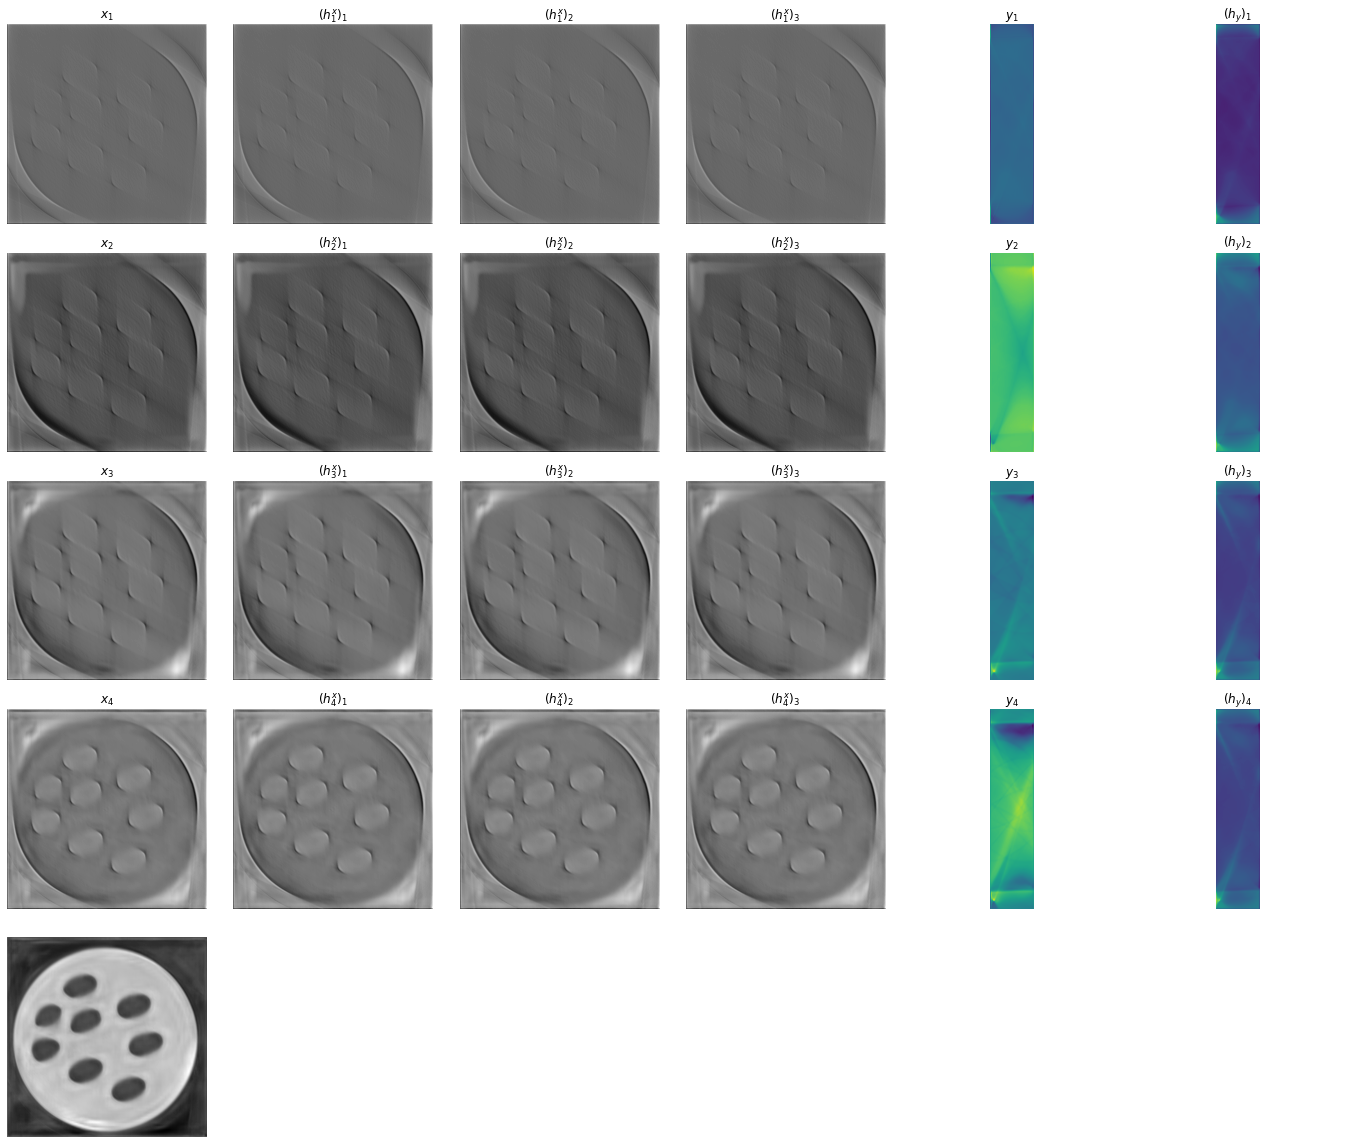

In [20]:
challenge_set = ChallengeData(angular_range=60, random_start_angle=False)

model = load_network(4)
sino, seg, angles = challenge_set[1]
sino = sino.unsqueeze(0)

with torch.no_grad():
    x_list, y_list = model.forward_full(sino)

fig, axes = plt.subplots(len(x_list), x_list[0].shape[1] + y_list[0].shape[1], figsize=(19,16))

for i in range(len(y_list)):
    
    axes[i, 0].imshow(x_list[i][0,0,:,:], cmap="gray")
    axes[i, 0].set_title(r"$x_{}$".format(i+1))
    
    axes[i, 1].imshow(x_list[i][0,1,:,:], cmap="gray")
    axes[i, 1].set_title(r"$(h^x_{})_1$".format(i+1))
    axes[i, 2].imshow(x_list[i][0,2,:,:], cmap="gray")
    axes[i, 2].set_title(r"$(h^x_{})_2$".format(i+1))
    axes[i, 3].imshow(x_list[i][0,3,:,:], cmap="gray")
    axes[i, 3].set_title(r"$(h^x_{})_3$".format(i+1))
    
    axes[i, 4].imshow(y_list[i][0,0,:,:].T)
    axes[i, 4].set_title(r"$y_{}$".format(i+1))
    axes[i, 5].imshow(y_list[i][0,1,:,:].T)
    axes[i, 5].set_title(r"$(h_y)_{}$".format(i+1))

for ax in axes.ravel():
    ax.axis("off")
axes[-1, 0].imshow(x_list[-1][0,0,:,:], cmap="gray")
plt.tight_layout()
plt.show()

    

To end on a positive note:

2. Training on simulated datasets may be a feasible option in application where only few ground truth images are available 
- But it depends strongly on the quality of the synthetic data
3. Learned iterative method, in particular learned primal-dual, has good generalization properties